In [21]:
import sys
sys.path.append('/home/kboone/software/Galaxy_Bias/Bispectrum/Convert_Bispectrum/')

In [22]:
import h5py
import glob
import numpy as np
from Helpers import *
from PIL import Image
from pathlib import Path
from Fits_Helpers import *
from Visual_Helpers import *
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.colors import CenteredNorm
from matplotlib.animation import FuncAnimation
from scipy.interpolate import CubicSpline as spline

In [23]:
phases = 25
data_dir = '/mnt/nvme1/kboone/Data/BigFiles/Gala_8/'
z = 8
rescale = (8+1)/(z+1)

L = 2000
N_grid = 256
kF = 2*np.pi/L
kN = N_grid*np.pi/L

In [24]:
2048*np.pi/L

3.2169908772759483

In [25]:
noises = get_noises()

In [26]:
init_guess = np.array([1.0, 1.0, 1.0, 10.0, 40.0, 100.0, 1.0])
fit_params = []
for ph in np.arange(phases):
    fit_params.append(np.load('Fits/Both_Best_Fits_'+str(ph)+'.npy')*init_guess)
fit_params = np.array(fit_params)

In [27]:
k, Pk = get_P(directory = data_dir)
std_P = np.std(Pk, axis=0)

kMax_P = kN

numBins = 10
kBins = np.geomspace(kF, kMax_P, numBins + 1)

b1b1_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b1b1_ps.dat'
b1b1_unbinned, b1b1 = sims_power(b1b1_file, kBins, numBins, W(k))
b1b1_unbinned *= rescale**2
b1b1 *= rescale**2

b2b2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2b2_ps.dat'
b2b2_unbinned, b2b2 = sims_power(b2b2_file, kBins, numBins, W(k))
b2b2_unbinned *= rescale**4
b2b2 *= rescale**4

b3b3_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b3b3_ps.dat'
b3b3_unbinned, b3b3 = sims_power(b3b3_file, kBins, numBins, W(k))
b3b3_unbinned *= rescale**6
b3b3 *= rescale**6

b2K2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2K2_ps.dat'
b2K2_unbinned, b2K2 = sims_power(b2K2_file, kBins, numBins, W(k), sym_factor=2)
b2K2_unbinned *= rescale**4
b2K2 *= rescale**4

b2F2_file = '/mnt/nvme1/kboone/Sims/PowerSpectra/b2F2_ps.dat'
b2F2_unbinned, b2F2 = sims_power(b2F2_file, kBins, numBins, W(k), sym_factor=2)
b2F2_unbinned *= rescale**4
b2F2 *= rescale**4

P1 = spline(k, b1b1_unbinned, bc_type='natural')
P2 = spline(k, b2b2_unbinned, bc_type='natural')
P3 = spline(k, b3b3_unbinned, bc_type='natural')
PK = spline(k, b2K2_unbinned, bc_type='natural')
PF = spline(k, b2F2_unbinned, bc_type='natural')

def P_model(params, noise):
    b0, b00, b000, b1, b2, b3, bK2 = params

    return W(k)**2 * (b1**2 * b1b1_unbinned + b2**2 * b2b2_unbinned + b3**2 * b3b3_unbinned + b1*b2*b2F2_unbinned + b2*bK2*b2K2_unbinned + b0*noise)

In [28]:
kF

0.0031415926535897933

In [29]:
kN

0.40212385965949354

In [30]:
# plot_ind = 0

# model = P_model(fit_params[plot_ind], noises[plot_ind])

# plt.figure(dpi = 120)
# plt.plot(k, Pk[plot_ind], label=r'Data $\pm 3\sigma$')
# plt.fill_between(k, (Pk[plot_ind]-3*std_P), (Pk[plot_ind]+3*std_P), alpha=0.5)
# plt.plot(k, model, label='Model', linestyle='--')
# # plt.axvline(x=kN/2, color = 'k', linestyle = '--')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel(r'$k$, h/Mpc')
# plt.ylabel(r'$P(k)$')
# plt.title('Individual Power Spectrum Fits')
# plt.legend()
# plt.grid()
# plt.show()

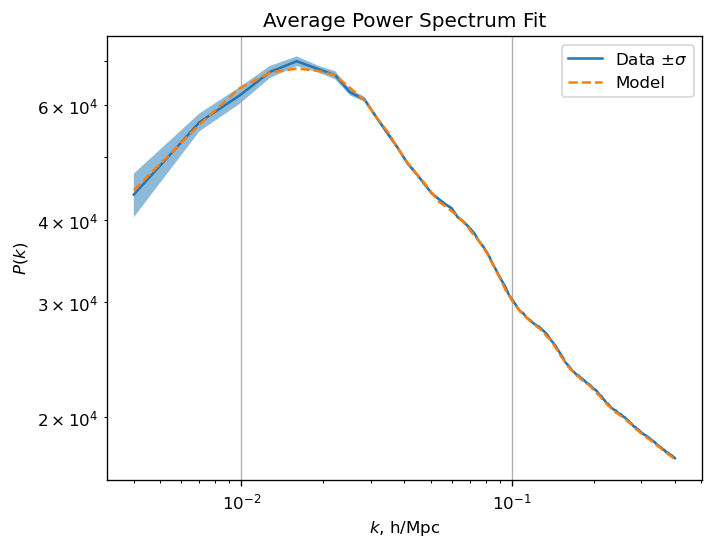

In [31]:
model = np.zeros(len(k))
for plot_ind in np.arange(phases):
    model += P_model(fit_params[plot_ind], noises[plot_ind])
model /= 25

data = np.zeros(len(k))
for plot_ind in np.arange(phases):
    data += Pk[plot_ind]
data /= 25

plt.figure(dpi = 120)
plt.plot(k, data, label=r'Data $\pm \sigma$')
plt.fill_between(k, (data-std_P/np.sqrt(phases)), (data+std_P/np.sqrt(phases)), alpha=0.5)
plt.plot(k, model, label='Model', linestyle='--')
# plt.axvline(x=kN/2, color = 'k', linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$k$, h/Mpc')
plt.ylabel(r'$P(k)$')
plt.title('Average Power Spectrum Fit')
plt.legend()
plt.grid()
plt.show()

In [32]:
Bs, k1, k2, k3, b1b1b2, b1b2b3, b2b2b2, b1b1K2, b1b1F2 = get_B(z, directory = data_dir)
std_B = np.std(Bs, axis=0)
ksum = k1 + k2 + k3

def B_model(params, noise):
    b0, b00, b000, b1, b2, b3, bK2 = params
    retval = W(k1)*W(k2)*W(k3)*(
        b1**2*b2 * b1b1b2 +
        b2**3 * b2b2b2 +
        b1*b2*b3 * b1b2b3 + 
        b1**2*bK2 * b1b1K2 + 
        b1**3 * b1b1F2 +
        -2*b00*b000 * noise**2 +
        3*b0*b00 * noise**2 +
        b00*b1**2 * noise * (P1(k1) + P1(k2) + P1(k3)) + 
        b00*b2**2 * noise * (P2(k1) + P2(k2) + P2(k3)) +
        b00*b3**2 * noise * (P3(k1) + P3(k2) + P3(k3)) +
        b00*b2*b1 * noise * (PF(k1) + PF(k2) + PF(k3)) +
        b00*b2*bK2 * noise * (PK(k1) + PK(k2) + PK(k3))
    )
    return retval

In [33]:
plot_ind = 11

k2_min = 100
k3_min = 100
k2_max = 0
k3_max = 0

circs = np.arange(33.5*kF, 127.5*kF, 2*kF)

for circ in circs:
    plot_inds = np.where(np.abs(ksum-circ) < kF)[0]
    
    k2_plot = k2[plot_inds]
    k3_plot = k3[plot_inds]

    if np.min(k2_plot) < k2_min:
        k2_min = np.min(k2_plot)
    if np.min(k3_plot) < k3_min:
        k3_min = np.min(k3_plot)

    if np.max(k2_plot) > k2_max:
        k2_max = np.max(k2_plot)
    if np.max(k3_plot) > k3_max:
        k3_max = np.max(k3_plot)

In [34]:
circ = circs[24]
    
plot_inds = np.where(np.abs(ksum-circ) < kF)[0]

k2_plot = k2[plot_inds]
k3_plot = k3[plot_inds]

model_plot = np.zeros(len(B_model(fit_params[0], noises[0])[plot_inds]))
for ind in np.arange(phases):
    model_plot += B_model(fit_params[ind], noises[ind])[plot_inds]
model_plot = model_plot / phases

data_plot = np.zeros(len(Bs[0][plot_inds]))
for ind in np.arange(phases):
    data_plot += Bs[ind][plot_inds]
data_plot = data_plot / phases

ks_tri = tri.Triangulation(k2_plot, k3_plot)

model_ver = plt.tripcolor(ks_tri, model_plot, shading='flat').get_array()
data_ver = plt.tripcolor(ks_tri, data_plot, shading='flat').get_array()
plt.close()
vmax = np.max([np.max(data_ver), np.max(model_ver)])
vmin = np.min([np.min(data_ver), np.min(model_ver)])

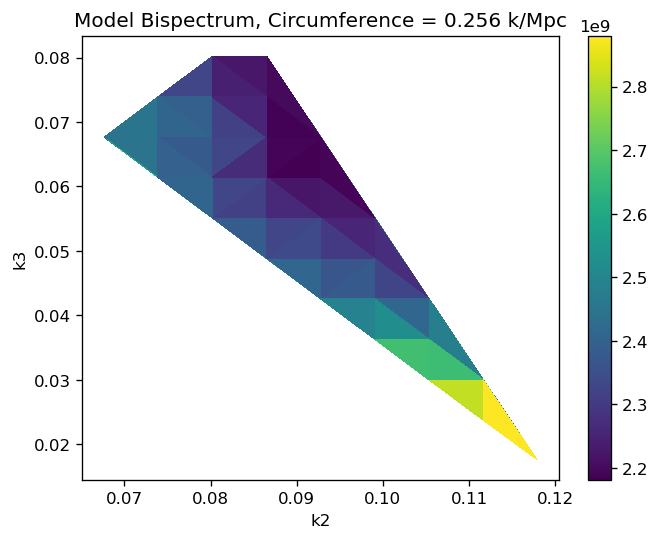

In [35]:
plt.figure(dpi=120)
plt.tripcolor(ks_tri, model_plot, shading='flat', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('k2')
plt.ylabel('k3')
plt.title('Model Bispectrum, Circumference = '+str(round(circ,3))+' k/Mpc')
plt.show()

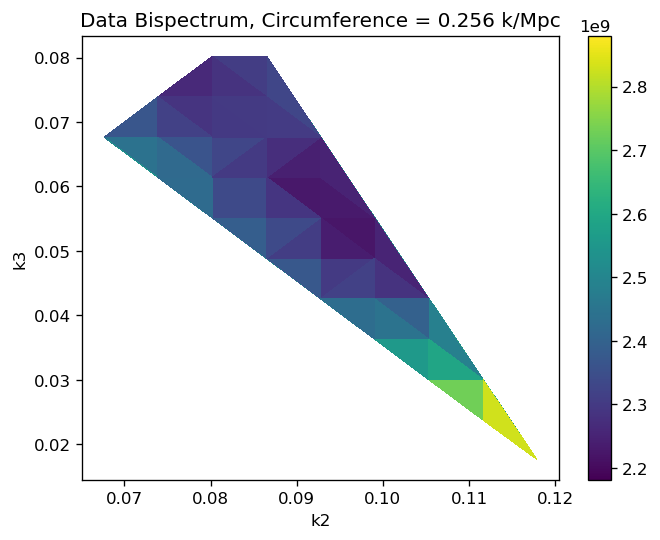

In [36]:
plt.figure(dpi=120)
plt.tripcolor(ks_tri, data_plot, shading='flat', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('k2')
plt.ylabel('k3')
plt.title('Data Bispectrum, Circumference = '+str(round(circ,3))+' k/Mpc')
plt.show()

In [17]:
for i in np.arange(len(circs)):
    circ = circs[i]
    
    plot_inds = np.where(np.abs(ksum-circ) < kF)[0]
    
    k2_plot = k2[plot_inds]
    k3_plot = k3[plot_inds]

    data_plot = Bs[plot_ind][plot_inds]
    model_plot = B_model(fit_params[plot_ind], noises[plot_ind])[plot_inds]
    std_plot = std_B[plot_inds]
    
    ks_tri = tri.Triangulation(k2_plot, k3_plot)
    
    plt.figure(dpi=120)
    plt.tripcolor(ks_tri, (model_plot-data_plot)/std_plot, shading='flat', cmap='bwr', norm=CenteredNorm(halfrange=3))
    plt.colorbar(label='Residual / Standard Deviation')
    plt.xlabel('k2')
    plt.ylabel('k3')
    # plt.xlim([k2_min, k2_max])
    # plt.ylim([k3_min, k3_max])
    plt.title('Residual / Standard Deviation, Circumference = '+str(round(circ,3)))
    plt.savefig('Plots/'+str(i)+'.png')
    plt.close()

In [18]:
folder = Path("./Plots")          # directory with 0.png, 1.png, ...
fps    = 4                 # frames per second
# ---------------------------------------

# Gather files named with plain integers and sort numerically
files = sorted(
    glob.glob(str(folder / "*.png")),
    key=lambda f: int(Path(f).stem)
)
if not files:
    raise FileNotFoundError("No numbered PNGs found in the chosen folder.")

# Pre-load images so playback is smooth
frames = [np.asarray(Image.open(f)) for f in files]

fig, ax = plt.subplots()
im = ax.imshow(frames[0], animated=True)
ax.axis("off")

def update(i):
    im.set_data(frames[i])
    return (im,)

ani = FuncAnimation(
    fig,
    update,
    frames=len(frames),
    interval=1000 / fps,   # milliseconds between frames
    blit=True,
    repeat=True,
)

# Render as HTML/JS; includes its own play/pause controls
html = ani.to_jshtml()
plt.close(fig)              # ⭐ prevent the duplicate static figure ⭐
display(HTML(html))